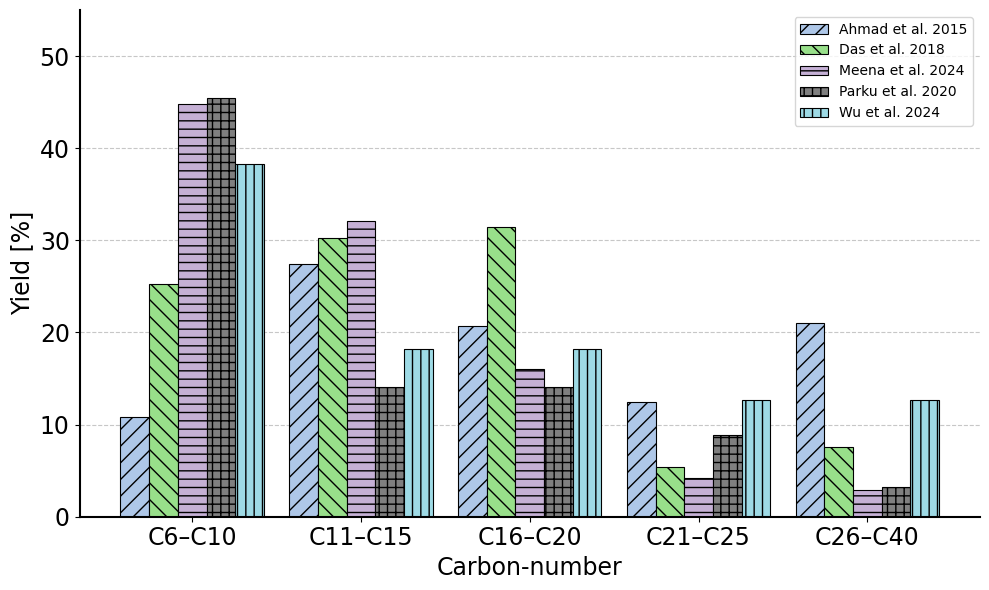

[OK] Figure saved to: HDPE_carbonNumber.png
[OK] Harmonized table saved to: PP_harmonized.csv


In [7]:
# Jupyter cell: read CSV -> harmonize to bins (if needed) -> grouped bar plot
# No seaborn, default matplotlib only.

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

# === 0) 설정 ===
INPUT_CSV = "./PP_input_example.csv"   # <- CSV 파일 경로
#OUT_PNG   = "HDPE_carbonNumber.png"
OUT_PDF   = "PP_carbonNumber.pdf"
OUT_CSV   = "PP_harmonized.csv"         # (형태 A일 때 생성)

# === 1) 공통 bin 정의 ===
BINS: List[Tuple[int, int, str]] = [
    (6, 10,"C6–C10"),
    (11, 15,"C11–C15"),
    (16, 20,"C16–C20"),
    (21, 25,"C21–C25"),
    (26, 40, "C26–C40"),
]
BIN_NAMES = [name for _, _, name in BINS]

def pick_colors(name: str, n: int):
    """지정한 컬러맵에서 n개의 색을 고르게 샘플링."""
    cmap = plt.get_cmap(name)
    xs = np.linspace(0.05, 0.95, max(n, 2))  # 양 끝단은 피함
    return [cmap(x) for x in xs[:n]]

def allocate_to_bins(reported_ranges: List[Dict[str, float]], bins=BINS) -> Dict[str, float]:
    """
    각 논문이 보고한 탄소수 구간(예: C6–C11 = 30%)을 공통 bin으로
    겹치는 탄소수 '개수 비례'로 분배합니다.
    reported_ranges = [{"low":6,"high":11,"pct":30.0}, ...]
    """
    out = {name: 0.0 for _, _, name in bins}
    max_high = max(h for _, h, _ in bins)
    for rr in reported_ranges:
        a = int(rr["low"]); b = int(rr["high"]); pct = float(rr["pct"])
        if b > max_high: 
            b = max_high
        if a > b: 
            continue
        width = (b - a + 1)
        if width <= 0:
            continue
        for (L, U, name) in bins:
            overlap_low  = max(a, L)
            overlap_high = min(b, U)
            if overlap_low <= overlap_high:
                overlap_cnt = (overlap_high - overlap_low + 1)
                out[name]  += pct * (overlap_cnt / width)
    # 근사 100%면 보정
    total = sum(out.values())
    if 99.0 <= total <= 101.0 and total != 0:
        out = {k: v * (100.0 / total) for k, v in out.items()}
    return out

# === 2) CSV 읽기 ===
df_in = pd.read_csv(INPUT_CSV)

# === 3) 입력 형태 판별 ===
has_raw  = {"Paper", "ReportedRangesJSON"}.issubset(df_in.columns)
has_bins = {"Paper", *BIN_NAMES}.issubset(set(df_in.columns))

if not has_raw and not has_bins:
    raise ValueError(
        "CSV 형식이 맞지 않습니다.\n"
        "형태 A) 컬럼 = [Paper, ReportedRangesJSON]\n"
        "형태 B) 컬럼 = [Paper, C4–C5, C6–C10, C11–C15, C16–C20, C21–C40]"
    )

# === 4) 공통 bin 표 만들기 ===
if has_raw:
    rows = []
    for _, r in df_in.iterrows():
        paper = str(r["Paper"])
        try:
            ranges = json.loads(r["ReportedRangesJSON"])
        except Exception as e:
            raise ValueError(f"ReportedRangesJSON 파싱 오류 (Paper='{paper}'): {e}")
        bucketed = allocate_to_bins(ranges, bins=BINS)
        rows.append({"Paper": paper, **bucketed})
    df_h = pd.DataFrame(rows).set_index("Paper")[BIN_NAMES].astype(float).round(3)
    df_h.to_csv(OUT_CSV)  # 참고용 저장
else:
    # 이미 bin별 열이 있는 경우
    df_h = df_in.set_index("Paper")[BIN_NAMES].astype(float).round(3)

# === 5) 플롯: x=구간, 각 구간에 논문 막대 나란히 (그룹형 막대) ===
df_bins = df_h.T  # index=bins, columns=papers
x_vals = np.arange(len(df_bins.index))
k = df_bins.shape[1]
group_width = 0.85
bar_width   = group_width / max(k, 1)

# 스타일 옵션
HATCHES = ["//", "\\\\", "--", "++", "||", "*", "-", "+", "O", "|"]
USE_HATCH = True
series_colors = pick_colors("tab20", k)     # 'tab10', 'Set2', 'viridis' 등 변경 가능

fig, ax = plt.subplots(figsize=(10, 6))

for i, col in enumerate(df_bins.columns):
    offsets = x_vals - group_width/2 + i*bar_width + bar_width/2
    ax.bar(
        offsets, df_bins[col].values,
        width=bar_width,
        label=col,
        color=series_colors[i],                    # 컬러맵
        edgecolor="black", linewidth=0.8,          # 엣지
        hatch=(HATCHES[i % len(HATCHES)] if USE_HATCH else None),  # 해치(옵션)
        zorder=2,
    )

# 축/스타일
ax.set_xticks(x_vals, df_bins.index)
ax.set_xlabel("Carbon-number", fontsize=17)
ax.set_ylabel("Yield [%]", fontsize=17)
ax.set_ylim(0, 55) 
ax.tick_params(axis="both", labelsize=17)
ax.legend(loc="upper right", fontsize=10, ncol=1)
ax.grid(axis="y", linestyle="--", alpha=0.7, zorder=0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
for s in ax.spines.values():
    s.set_linewidth(1.5)

fig.tight_layout()
fig.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
fig.savefig(OUT_PDF)
plt.show()

print(f"[OK] Figure saved to: {OUT_PNG}")
if has_raw:
    print(f"[OK] Harmonized table saved to: {OUT_CSV}")


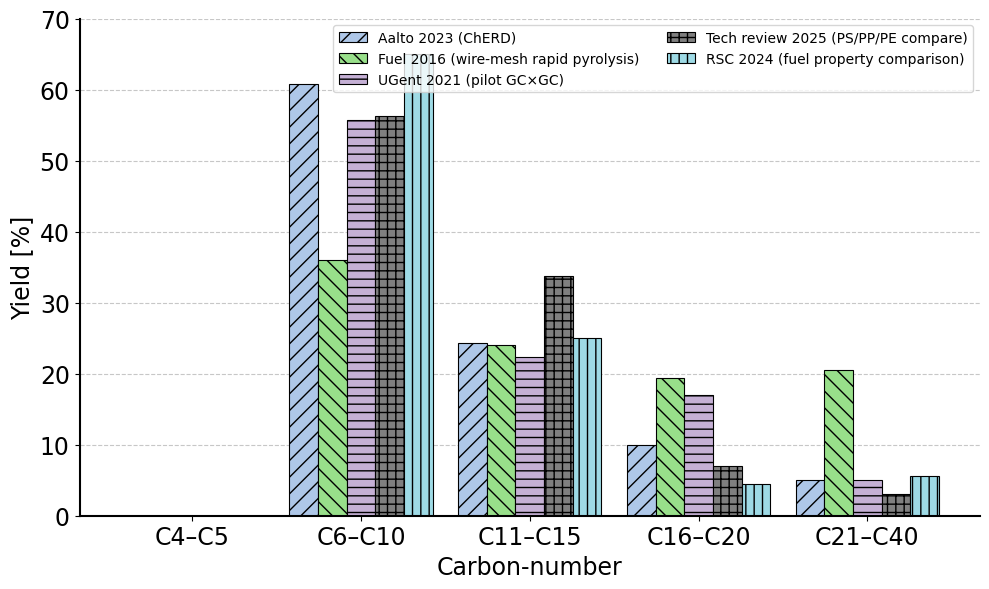

[OK] Figure saved to: PS_grouped.png
[OK] Harmonized table saved to: PS_harmonized.csv


In [36]:
# Jupyter cell: read CSV -> harmonize to bins (if needed) -> grouped bar plot
# No seaborn, default matplotlib only.

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

# === 0) 설정 ===
INPUT_CSV = "./PS_input_example.csv"   # <- CSV 파일 경로
OUT_PNG   = "PS_grouped.png"
OUT_PDF   = "PS_grouped.pdf"
OUT_CSV   = "PS_harmonized.csv"         # (형태 A일 때 생성)

# === 1) 공통 bin 정의 ===
BINS: List[Tuple[int, int, str]] = [
    (4, 5,  "C4–C5"),
    (6, 10, "C6–C10"),
    (11, 15,"C11–C15"),
    (16, 20,"C16–C20"),
    (21, 40,"C21–C40"),
]
BIN_NAMES = [name for _, _, name in BINS]

def pick_colors(name: str, n: int):
    """지정한 컬러맵에서 n개의 색을 고르게 샘플링."""
    cmap = plt.get_cmap(name)
    xs = np.linspace(0.05, 0.95, max(n, 2))  # 양 끝단은 피함
    return [cmap(x) for x in xs[:n]]

def allocate_to_bins(reported_ranges: List[Dict[str, float]], bins=BINS) -> Dict[str, float]:
    """
    각 논문이 보고한 탄소수 구간(예: C6–C11 = 30%)을 공통 bin으로
    겹치는 탄소수 '개수 비례'로 분배합니다.
    reported_ranges = [{"low":6,"high":11,"pct":30.0}, ...]
    """
    out = {name: 0.0 for _, _, name in bins}
    max_high = max(h for _, h, _ in bins)
    for rr in reported_ranges:
        a = int(rr["low"]); b = int(rr["high"]); pct = float(rr["pct"])
        if b > max_high: 
            b = max_high
        if a > b: 
            continue
        width = (b - a + 1)
        if width <= 0:
            continue
        for (L, U, name) in bins:
            overlap_low  = max(a, L)
            overlap_high = min(b, U)
            if overlap_low <= overlap_high:
                overlap_cnt = (overlap_high - overlap_low + 1)
                out[name]  += pct * (overlap_cnt / width)
    # 근사 100%면 보정
    total = sum(out.values())
    if 99.0 <= total <= 101.0 and total != 0:
        out = {k: v * (100.0 / total) for k, v in out.items()}
    return out

# === 2) CSV 읽기 ===
df_in = pd.read_csv(INPUT_CSV)

# === 3) 입력 형태 판별 ===
has_raw  = {"Paper", "ReportedRangesJSON"}.issubset(df_in.columns)
has_bins = {"Paper", *BIN_NAMES}.issubset(set(df_in.columns))

if not has_raw and not has_bins:
    raise ValueError(
        "CSV 형식이 맞지 않습니다.\n"
        "형태 A) 컬럼 = [Paper, ReportedRangesJSON]\n"
        "형태 B) 컬럼 = [Paper, C4–C5, C6–C10, C11–C15, C16–C20, C21–C40]"
    )

# === 4) 공통 bin 표 만들기 ===
if has_raw:
    rows = []
    for _, r in df_in.iterrows():
        paper = str(r["Paper"])
        try:
            ranges = json.loads(r["ReportedRangesJSON"])
        except Exception as e:
            raise ValueError(f"ReportedRangesJSON 파싱 오류 (Paper='{paper}'): {e}")
        bucketed = allocate_to_bins(ranges, bins=BINS)
        rows.append({"Paper": paper, **bucketed})
    df_h = pd.DataFrame(rows).set_index("Paper")[BIN_NAMES].astype(float).round(3)
    df_h.to_csv(OUT_CSV)  # 참고용 저장
else:
    # 이미 bin별 열이 있는 경우
    df_h = df_in.set_index("Paper")[BIN_NAMES].astype(float).round(3)

# === 5) 플롯: x=구간, 각 구간에 논문 막대 나란히 (그룹형 막대) ===
df_bins = df_h.T  # index=bins, columns=papers
x_vals = np.arange(len(df_bins.index))
k = df_bins.shape[1]
group_width = 0.85
bar_width   = group_width / max(k, 1)

# 스타일 옵션
HATCHES = ["//", "\\\\", "--", "++", "||", "*", "-", "+", "O", "|"]
USE_HATCH = True
series_colors = pick_colors("tab20", k)     # 'tab10', 'Set2', 'viridis' 등 변경 가능

fig, ax = plt.subplots(figsize=(10, 6))

for i, col in enumerate(df_bins.columns):
    offsets = x_vals - group_width/2 + i*bar_width + bar_width/2
    ax.bar(
        offsets, df_bins[col].values,
        width=bar_width,
        label=col,
        color=series_colors[i],                    # 컬러맵
        edgecolor="black", linewidth=0.8,          # 엣지
        hatch=(HATCHES[i % len(HATCHES)] if USE_HATCH else None),  # 해치(옵션)
        zorder=2,
    )

# 축/스타일
ax.set_xticks(x_vals, df_bins.index)
ax.set_xlabel("Carbon-number", fontsize=17)
ax.set_ylabel("Yield [%]", fontsize=17)
ax.set_ylim(0, 70) 
ax.tick_params(axis="both", labelsize=17)
ax.legend(loc="upper right", fontsize=10, ncol=2)
ax.grid(axis="y", linestyle="--", alpha=0.7, zorder=0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
for s in ax.spines.values():
    s.set_linewidth(1.5)

fig.tight_layout()
fig.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
fig.savefig(OUT_PDF)
plt.show()

print(f"[OK] Figure saved to: {OUT_PNG}")
if has_raw:
    print(f"[OK] Harmonized table saved to: {OUT_CSV}")
